In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import hvplot.pandas
%matplotlib inline

## Setting up Cheeseburger dataframe

In [382]:
everything = pd.read_csv(r'C:\Users\harr1\Desktop\Merged_Data_US_noJuly.csv')

everything=everything.drop(['Unnamed: 0'], axis=1)
everything

########################Setting up burger info############################
chzbrg = everything[everything['Menu Item']=='Cheeseburger'] 
hambrg = everything[everything['Menu Item']=='Hamburger']
abe = everything[everything['Menu Item']=='A.B.E Burger']
poivre = everything[everything['Menu Item']=='Au Poivre Burger']
cowboy = everything[everything['Menu Item']=='Cowboy Jack Burger']
swiss = everything[everything['Menu Item']=='Sauteed & Swiss Burger']

frames = [chzbrg,hambrg,abe,poivre,cowboy,swiss]
chzbrg = pd.concat(frames)

chzbrg = chzbrg.drop(['Menu Group', 'Menu Item'], axis = 1)

#Consolodating dates for no duplicates
chzbrg = chzbrg.groupby('time_adjust').agg({'Item Qty': 'sum', 'Guests':'first', 'apparentTemperature':'first',  
                               'cloudCover':'first',  'dewPoint':'first', 'humidity':'first',
                                'ozone': 'first', 'pressure':'first',  'temperature':'first',  'uvIndex':'first',  
                               'visibility':'first', 'windBearing':'first',  'windGust':'first',  
                               'windSpeed':'first',  'Day_encoded':'first', 'weather':'first', 
                                'summary_num': 'first', 'hours':'first', 'month': 'first'
                                }).reset_index()
####################################Feature Engineering#########################

#Probability of ordering a burger for every day previously
chzbrg['Prob']= chzbrg['Item Qty']/chzbrg['Guests']
chzbrg

#Probability of ordering a burger on the same day in the week prior
count = 0
prob_last = []
i=0
while count < 178:
    for each in chzbrg['Prob']:
        if count <= 6:
            prob_last.append(each)
            count = count +1
        elif count >6:
            prob_last.append(chzbrg['Prob'][i])
            count = count+1
            i = i +1
len(prob_last)
chzbrg['Prob_last'] = prob_last

#Probability of ordering a burger per day of the week averaged over 6 months
chzbrg['Prob_ave'] = chzbrg.groupby('Day_encoded')['Prob'].transform('mean')

#Number of burgers ordered per day of the week averaged over 6 months
chzbrg['Item_ave'] = chzbrg.groupby('Day_encoded')['Item Qty'].transform('mean')

#Average number of burgers ordered per day of the week per month 
chzbrg['Quant_dm']= chzbrg.groupby(['month', 'Day_encoded'])['Item Qty'].transform('mean')

#Number of guests dividing into groups of 25
guest_grp = []
for x in chzbrg['Guests']:
    if x <= 25:
        guest_grp.append(1)
    elif 25< x <= 50:
        guest_grp.append(2)
    elif 50 < x <= 75:
        guest_grp.append(3)
    elif 75< x <= 100:
        guest_grp.append(4)
    elif 100< x <= 125:
        guest_grp.append(5)
    elif 125< x <= 150:
        guest_grp.append(6)
    elif 150< x <= 175:
        guest_grp.append(7)
    elif 175< x <= 200:
        guest_grp.append(8)
    elif 200< x <= 225:
        guest_grp.append(9)
    elif 225< x <= 250:
        guest_grp.append(10)
    elif 250< x <= 275:
        guest_grp.append(11)
    elif 275< x <= 300:
        guest_grp.append(12)
    elif 300< x <= 325:
        guest_grp.append(13)
    elif 325< x <= 350:
        guest_grp.append(14)
    elif 350< x <= 375:
        guest_grp.append(15)
    elif 375< x <= 400:
        guest_grp.append(16)
    else:
        guest_grp.append(17)
        
chzbrg['guest_grp'] = guest_grp

#Average probability of ordering a burger depending on the categorized 
#amount of guests in the building that day
chzbrg['guest_grp_prob'] = chzbrg.groupby('guest_grp')['Prob'].transform('mean')

#Ave probability of ordering a burger based on guest count 
#multiplied by probability average per day of the week
chzbrg['interact']= chzbrg['guest_grp_prob'] * chzbrg['Prob_ave']
chzbrg

#Dropping nulls
null = chzbrg.isnull().sum()
chzbrg = chzbrg.dropna()

#Dropping Probability as it is not a realistic measure
chzbrg=chzbrg.drop(['Prob'], axis=1)
chzbrg.time_adjust.max()

178.0

## End feature engineering

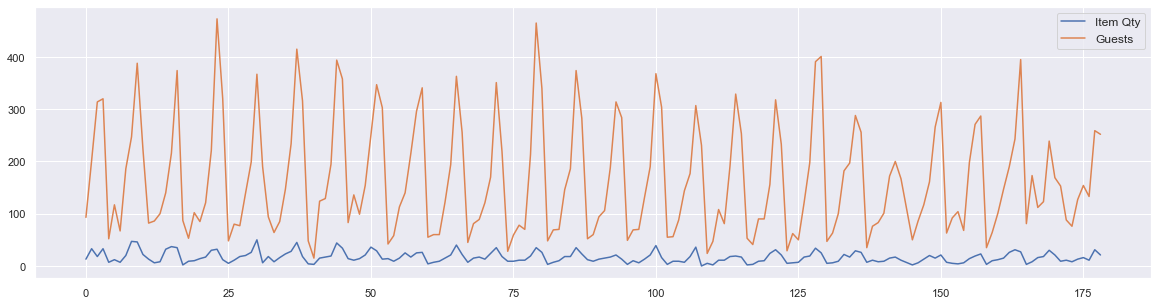

In [218]:
plt.figure(figsize=(20,5))
plt.plot('time_adjust', 'Item Qty', data=chzbrg)
plt.plot('time_adjust', 'Guests', data=chzbrg)

plt.legend(fontsize=12)
plt.show()

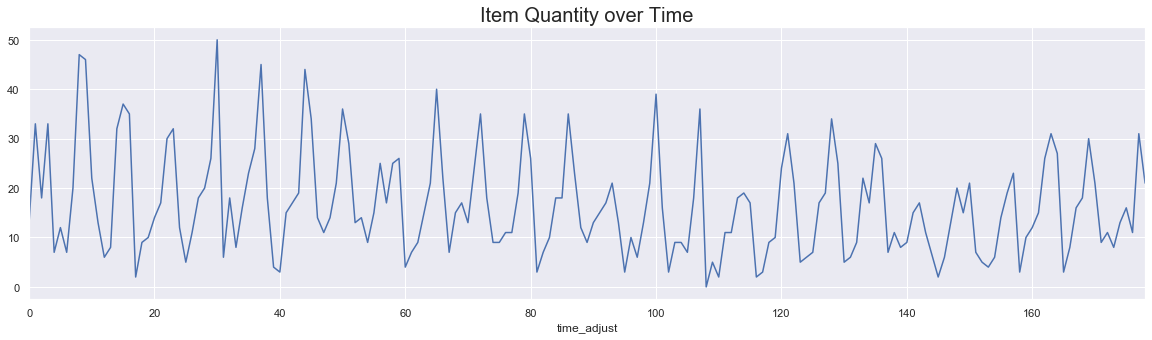

In [219]:
import seaborn as sns

import seaborn as sns; sns.set()

plt.figure(figsize= (20,5))
plt.title('Item Quantity over Time', fontsize=20)
chzbrg.groupby(['time_adjust'])['Item Qty'].sum().plot()
#plt.ylim(0, 100)

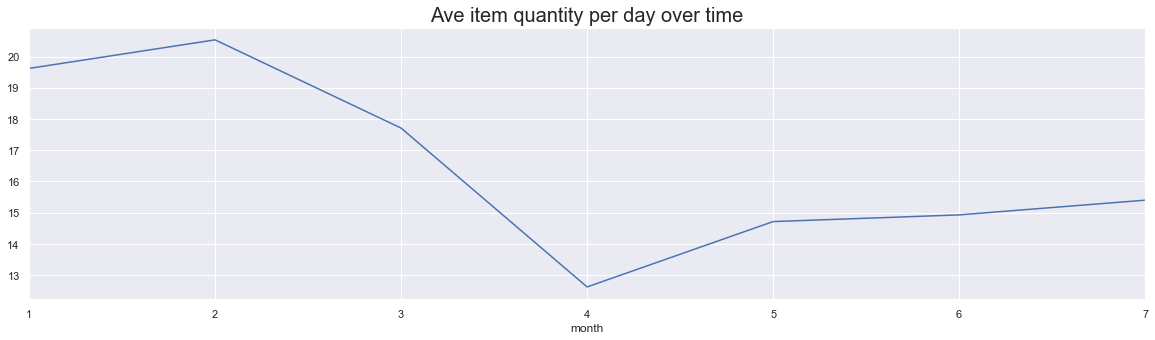

In [220]:

plt.figure(figsize= (20,5))
plt.title('Ave item quantity per day over time', fontsize=20)
chzbrg.groupby(['month'])['Quant_dm'].mean().plot()
#plt.ylim(0, 100)

# Modeling Cheeseburgers

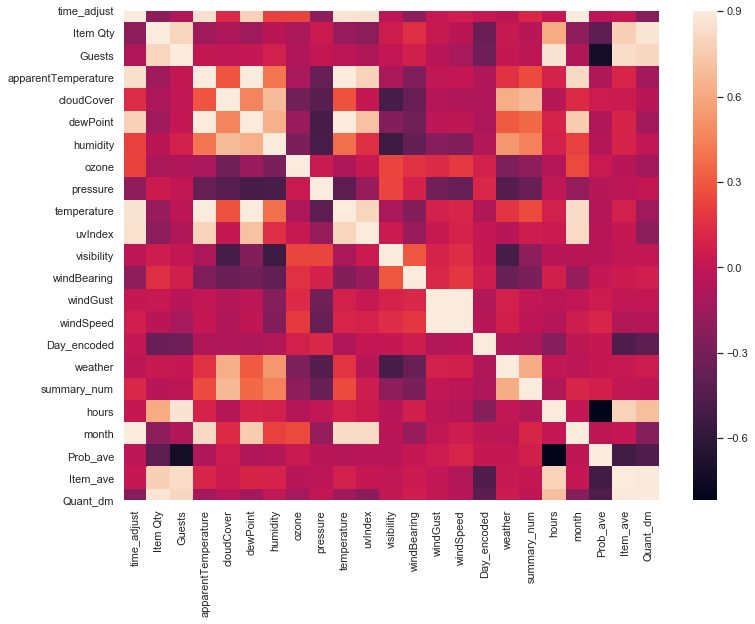

In [181]:
corrmat = chzbrg.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9)
plt.show()

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets

In [130]:
chzbrg.to_csv(r'C:\Users\harr1\Desktop\Prediction_data_US2.csv')

In [358]:
data = chzbrg.drop(['Item Qty'], axis = 1)
target = chzbrg['Item Qty']

RandForest= ensemble.RandomForestRegressor()

RandForest.fit(data,target)


RandForest.feature_importances_
RandForest_ft_series = pd.Series(data=RandForest.feature_importances_, index=data.columns)
###################################
sorted_series = RandForest_ft_series.sort_values(ascending = False)
sorted_series

c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Quant_dm               0.708135
Guests                 0.068648
guest_grp              0.034030
dewPoint               0.020872
ozone                  0.019048
Prob_last              0.018439
pressure               0.014834
windSpeed              0.014423
interact               0.011146
humidity               0.010883
time_adjust            0.010875
windBearing            0.010461
summary_num            0.009563
windGust               0.009176
apparentTemperature    0.007343
guest_grp_prob         0.007337
visibility             0.006200
cloudCover             0.004664
temperature            0.004351
weather                0.003060
Day_encoded            0.001874
month                  0.001765
hours                  0.001486
Item_ave               0.000670
Prob_ave               0.000474
uvIndex                0.000242
dtype: float64

In [359]:
#Setting up three different models

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(data, target, test_size =.10, random_state=42)


#Medium model
data_m = chzbrg[['time_adjust', 'Quant_dm','Guests', 'guest_grp_prob','Day_encoded', 'dewPoint', 'apparentTemperature', 'temperature']]
target_m = chzbrg['Item Qty']
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(data_m, target_m, test_size =.10, random_state=42)


#Super simple model
data_s=chzbrg[['Guests','Quant_dm', 'guest_grp_prob']]
target_s=chzbrg[['Item Qty']]
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(data_s,target_s,test_size=.10, random_state=42)

#my thoughts
data_me=chzbrg[['Guests', 'hours', 'Quant_dm', 'time_adjust', 'interact', 'guest_grp_prob', 'guest_grp']]
target_me=chzbrg[['Item Qty']]
x_train_me, x_test_me, y_train_me, y_test_me = train_test_split(data_me,target_me,test_size=.10, random_state=42)


# Linear Regression = med best at .48, .76std

In [360]:
#most of the variables
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
#Long data

long_val_scores = cross_val_score(lm, data,target,cv=10, scoring = 'explained_variance')
print('Long mean: ' , long_val_scores.mean())
print('Long std: ' , long_val_scores.std())
#print('Prediction:', lm.predict(x_test_l))

#Medium data

med_val_scores= cross_val_score(lm, data_m,target_m,cv=10, scoring = 'explained_variance')
print('\nMed mean: ' , med_val_scores.mean())
print('Med std: ' , med_val_scores.std())
#print('Prediction:', lm.predict(x_test_m))


#Short data

short_val_scores= cross_val_score(lm, data_s,target_s,cv=10, scoring = 'explained_variance')
print('\nShort mean: ' , short_val_scores.mean())
print('Short std: ' , short_val_scores.std())
#print('Prediction:', lm.predict(x_test_s))

#mine

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

short_val_scores= cross_val_score(lm, data_me,target_me,cv=10, scoring = 'explained_variance')
print('\nMy mean: ' , short_val_scores.mean())
print('My std: ' , short_val_scores.std())


Long mean:  0.7711443393583275
Long std:  0.09822702196533593

Med mean:  0.7689397244736449
Med std:  0.07233825250354776

Short mean:  0.7797056560238809
Short std:  0.07880316846985734

My mean:  0.8074785059630312
My std:  0.08381036585347203


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
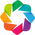

In [278]:
import arrow
import hvplot



import holoviews as hv
hv.extension('bokeh')

chzbrg[['time_adjust', 'Item Qty']].hvplot()
plt.show()

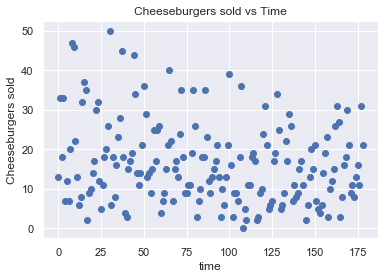

In [186]:
plt.scatter(x = chzbrg['time_adjust'], y = chzbrg['Item Qty'])
plt.title('Cheeseburgers sold vs Time')
plt.xlabel('time')
plt.ylabel('Cheeseburgers sold')
plt.show()

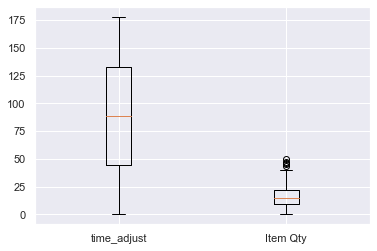

In [187]:
plt.boxplot([chzbrg.time_adjust, chzbrg['Item Qty']])
plt.xticks([1,2], ['time_adjust','Item Qty'])
plt.show()

# Huber Regression = med best at .47, .53std

In [332]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

# #long model

long_val_scores = cross_val_score(hr, data,target,cv=10, scoring = 'explained_variance')
print('Long mean: ' , long_val_scores.mean())
print('Long std: ' , long_val_scores.std())

#medium model
med_val_scores= cross_val_score(hr, data_m,target_m,cv=10, scoring = 'explained_variance')
print('\nMed mean: ' , med_val_scores.mean())
print('Med std: ' , med_val_scores.std())
#print('Prediction:', lm.predict(x_test_m))

#Short data

short_val_scores= cross_val_score(hr, data_s,target_s,cv=10, scoring = 'explained_variance')
print('\nShort mean: ' , short_val_scores.mean())
print('Short std: ' , short_val_scores.std())
#print('Prediction:', lm.predict(x_test_s))

#My data

short_val_scores= cross_val_score(hr, data_me,target_me,cv=10, scoring = 'explained_variance')
print('\nMy mean: ' , short_val_scores.mean())
print('my std: ' , short_val_scores.std())
#print('Prediction:', lm.predict(x_test_s))



Long mean:  0.7838632952457435
Long std:  0.06323080697944383

Med mean:  0.7692002419471191
Med std:  0.07402407915908009


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversio


Short mean:  0.7808872020591809
Short std:  0.06875305070798743


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversio


My mean:  0.800501672421192
my std:  0.07416046018046656


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Ridge = short best at .63, .37std. 

## Doesn't really make sense to use such a small model for ridge though

In [333]:
#long data
from sklearn.linear_model import RidgeCV

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data, target)
print ('all data alpha:', find_alpha.alpha_)

#medium data

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_m, target_m)
print ('medium data alpha:', find_alpha.alpha_)


#short data

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_s, target_s)
print ('short data alpha:', find_alpha.alpha_)

# #my data

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_me, target_me)
print ('short data alpha:', find_alpha.alpha_)




all data alpha: 0.01
medium data alpha: 0.01
short data alpha: 0.01
short data alpha: 0.001


In [334]:
#long data
ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data, target, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean all data:', np.mean(cross_variable))
print ('Stdv all data:',np.std(cross_variable))

#nedium data
ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data_m, target_m, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean med data:', np.mean(cross_variable))
print ('Stdv med data:',np.std(cross_variable))


#simple data
ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data_s, target_s, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean short data:', np.mean(cross_variable))
print ('Stdv short data:',np.std(cross_variable))

# #my data
ridgeregr = linear_model.Ridge(alpha = .001, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data_me, target_me, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean my data:', np.mean(cross_variable))
print ('Stdv my data:',np.std(cross_variable))


Optimized alphas
Cross Validation: 
 [0.7605405  0.82087378 0.83974744 0.82961411 0.91477585 0.80368054
 0.71180301 0.83100816 0.7204248  0.6417909 ]
Mean all data: 0.7874259083149203
Stdv all data: 0.07493873068281126

Optimized alphas
Cross Validation: 
 [0.69200153 0.73409358 0.78988887 0.80569281 0.94773709 0.79880891
 0.69520374 0.76027327 0.79276725 0.69443402]
Mean med data: 0.7710901076153547
Stdv med data: 0.07305393582883829

Optimized alphas
Cross Validation: 
 [0.68401014 0.75196662 0.78274928 0.82928748 0.95067032 0.82837739
 0.69328805 0.75909861 0.790822   0.68349477]
Mean short data: 0.775376465896441
Stdv short data: 0.07815235197953734

Optimized alphas
Cross Validation: 
 [0.76617676 0.80239273 0.85171166 0.84167826 0.95415909 0.79444862
 0.73289855 0.84337383 0.78437239 0.64253834]
Mean my data: 0.8013750224875393
Stdv my data: 0.07794878824238193


# Best model Gradient Boost-smallest data best, .951 .033std

In [335]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 5,
           'max_features':4,
#max_features has the largest impact on this model
          'subsample': .8,
          'alpha': .5,
         'random_state':42}

# Long
clf = ensemble.GradientBoostingRegressor(**params)

cross_variable=cross_val_score(clf, data, target, cv=10, scoring = 'explained_variance')
print('Cross Validation: \n', cross_variable)
print ('Mean all data:', np.mean(cross_variable))
print ('Stdv all data:',np.std(cross_variable))

params = {'n_estimators': 250,
          'max_depth': 5,
           'max_features':3,
          #sqrt of total number of features
#max_features has the largest impact on this model
          'subsample': .8,
          'alpha': .5,
         'random_state':42}

clf = ensemble.GradientBoostingRegressor(**params)

# Medium

cross_variable=cross_val_score(clf, data_m, target_m, cv=10, scoring = 'explained_variance')
print('\nCross Validation: \n', cross_variable)
print ('Mean med data:', np.mean(cross_variable))
print ('Stdv med data:',np.std(cross_variable))

params = {'n_estimators': 189,
          #500 worked really well. Will 100?
          'max_depth': 6,
           'max_features':3,
          #should I even  define max_features?This seems to have a largest impact on this model
         'random_state':42}

clf = ensemble.GradientBoostingRegressor(**params)

# Short

cross_variable=cross_val_score(clf, data_s, target_s, cv=10, scoring = 'explained_variance')
print('\nCross Validation: \n', cross_variable)
print ('Mean s data:', np.mean(cross_variable))
print ('Stdv s data:',np.std(cross_variable))

params = {'n_estimators': 250,
          #500 worked really well. Will 100?
          'max_depth': 5,
           'max_features':2,
          #should I even  define max_features?This seems to have a largest impact on this model

          'subsample': .8,
          'alpha': .5,
         'random_state':42}

# #My
clf = ensemble.GradientBoostingRegressor(**params)

cross_variable=cross_val_score(clf, data_me, target_me, cv=10, scoring = 'explained_variance')
print('\nCross Validation: \n', cross_variable)
print ('Mean me data:', np.mean(cross_variable))
print ('Stdv me data:',np.std(cross_variable))




Cross Validation: 
 [0.62357601 0.76097918 0.73303863 0.83050602 0.89983362 0.71320752
 0.59246757 0.81119113 0.50637414 0.51455985]
Mean all data: 0.698573366338245
Stdv all data: 0.1278967306942046

Cross Validation: 
 [0.66749956 0.60750105 0.73896283 0.82312797 0.92237176 0.80119653
 0.65932144 0.65369634 0.61282611 0.44582802]
Mean med data: 0.6932331597547631
Stdv med data: 0.127092260994107


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensem


Cross Validation: 
 [0.57740319 0.47900711 0.68462286 0.79529447 0.81510086 0.71228376
 0.62321517 0.30405902 0.37374901 0.30414248]
Mean s data: 0.5668877921241581
Stdv s data: 0.18308573886041873


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensem


Cross Validation: 
 [0.65868165 0.55211834 0.84814675 0.86936719 0.93774381 0.7899775
 0.60806828 0.80721877 0.46805397 0.53620625]
Mean me data: 0.7075582513787986
Stdv me data: 0.15454137189382225


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Random Forest-smallest best .93, std .052

In [336]:
#optimizing parameters: had very little effect

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv =3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
lrg_fit = rf_random.fit(x_train_l, y_train_l)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [337]:
lrg_fit=rf_random.fit(x_train_l, y_train_l)
m_fit = rf_random.fit(x_train_m, y_train_m)
s_fit = rf_random.fit(x_train_s, y_train_s)
me_fit=rf_random.fit(x_train_me, y_train_me)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [343]:
#lrg_fit.best_params_
print (lrg_fit.best_params_)
print (m_fit.best_params_)
print (s_fit.best_params_)
print(me_fit.best_params_)

{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [344]:

#all data
params={'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

RandForest= ensemble.RandomForestRegressor(**params)


cross_variable=cross_val_score(RandForest, data, target, cv=10)
print('Cross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

#Medium data

# params={'n_estimators': 1000,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 20,
#  'bootstrap': True}

# RandForest= ensemble.RandomForestRegressor(**params)

cross_variable=cross_val_score(RandForest, data_m, target_m, cv=10)
print('\nCross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

#Short data

# params={'n_estimators': 1000,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 20,
#  'bootstrap': True}
# RandForest= ensemble.RandomForestRegressor(**params)

cross_variable=cross_val_score(RandForest, data_s, target_s, cv=10)
print('\nCross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

# params={'n_estimators': 1000,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 20,
#  'bootstrap': True}
# RandForest= ensemble.RandomForestRegressor(**params)

cross_variable=cross_val_score(RandForest, data_me, target_me, cv=10)
print('\nCross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))


Cross Validation: 
 [0.5852853  0.66323111 0.77532036 0.80891963 0.94374407 0.76639986
 0.54092348 0.77294538 0.54948193 0.5541638 ]
Mean: 0.6960414922113766
std: 0.13048437692799514

Cross Validation: 
 [0.62675875 0.59540946 0.75911569 0.80183569 0.91492493 0.77235205
 0.58604101 0.73855934 0.63755024 0.4894568 ]
Mean: 0.6922003959202823
std: 0.11987065127991044


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\pytho


Cross Validation: 
 [0.59370599 0.68281544 0.8071121  0.84324208 0.92753788 0.803969
 0.42743798 0.7280771  0.60111049 0.60755583]
Mean: 0.7022563873866579
std: 0.14125175536513868


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\pytho


Cross Validation: 
 [0.59118343 0.69041955 0.82366391 0.84578403 0.94766693 0.79479715
 0.55814253 0.79310339 0.58181215 0.57615038]
Mean: 0.720272345210313
std: 0.13145081933992525


# XGBoost-med best 0.8517, std 0.074

In [27]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [28]:
xgb = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
cross_variable=cross_val_score(xgb, data, target, cv=10)
print('\nCross Validation long: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

cross_variable=cross_val_score(xgb, data_m, target_m, cv=10)
print('\nCross Validation medium: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

cross_variable=cross_val_score(xgb, data_s, target_s, cv=10)
print('\nCross Validation short: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

# cross_variable=cross_val_score(xgb, data_me, target_me, cv=10)
# print('\nCross Validation short: \n', cross_variable)
# print ('Mean:', np.mean(cross_variable))
# print ('std:',np.std(cross_variable))



c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Cross Validation long: 
 [0.79244693 0.86430253 0.90307277 0.87414811 0.92769269 0.81266084
 0.81027566 0.87841449 0.90695586 0.66412623]
Mean: 0.8434096107165946
std: 0.07354674682743001
[18:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Cross Validation medium: 
 [0.8068552  0.90170244 0.89061829 0.89117829 0.92772286 0.8546886
 0.77910879 0.86523747 0.90379856 0.80320463]
Mean: 0.862411512983377
std: 0.047691002574063494
[18:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squa

# Prediction Time!

In [366]:
#July Data

# guest_count = [58,115,89,0,89,231,
#               182,42,78,77,128,159,229,
#               390,80]
               

# total_df = pd.DataFrame()

# days_passed = 0
# i=0

# from glob import glob

# for file in glob(r'C:\Users\harr1\Desktop\Union Straw July\*csv'):
        

#     df = pd.read_csv(file, index_col = 0)
    
# #Dropping empty/summary rows and superfluous information
#     df = df.dropna(subset = ['Menu Item'])
#     df_shrt = df[['Menu Group', 'Menu Item', 'Item Qty']]

# #Assigning date for dataframe
#     open_date= "07/01/19"
#     opening_date_dt = datetime.datetime.strptime(open_date, "%m/%d/%y")

#     end_date = opening_date_dt + datetime.timedelta(days=days_passed)

#     df_shrt['Date'] = end_date
#     df_shrt['DOTW'] = end_date.strftime("%A")
    
#     df_shrt['Guests'] = guest_count[i]
    
#     total_df = total_df.append(df_shrt)
    
#     days_passed = days_passed+1
#     i= i +1
    
   
# total_df = total_df.replace('Sandwiches','Sandwiches & Salads')
# July = total_df.replace('Salads', 'Sandwiches & Salads')
# July['Menu Group'].nunique()

# # df_shrt

# July = July[July['Menu Group']!='Easter Mains']
# July = July[July['Menu Group']!='Gift Cards']
# July = July[July['Menu Group']!='Open Food']
# July = July[July['Menu Group']!='Sides']
# July = July[July['Menu Group']!='Salad']
# July = July[July['Menu Group']!='Soup']
# July = July[July['Menu Group']!='Brunch Small Bites']


# Monday = July[July['DOTW'] == 'Monday']
# Tuesday = July[July['DOTW'] == 'Tuesday']
# Wednesday = July[July['DOTW'] == 'Wednesday']
# Thursday = July[July['DOTW'] == 'Thursday']
# Friday = July[July['DOTW'] == 'Friday']
# Saturday = July[July['DOTW'] == 'Saturday']
# Sunday = July[July['DOTW'] == 'Sunday']


# #Weather API################################################################

# # number = 1561982400

# # temp_df = pd.DataFrame()

# # while number<= 1563192000:
    
# #     str_numb = str(number)
# #     ds_api = pd.read_json('https://api.darksky.net/forecast/b622e33984ce098528bf825a17d61d04/42.065995,-71.2494761,{}?exclude=daily,exclude=hourly,flags'.format(str_numb), orient='records')

# #     temp_df = temp_df.append(ds_api)
# #     number = number + 86400 

# # temp_df.drop(['timezone','latitude','longitude','offset'],1,inplace=True)
# ###########################################################################################

# temp_df.to_csv(r'C:\Users\harr1\Desktop\July_weather.csv')
# july_weather = pd.read_csv(r'C:\Users\harr1\Desktop\July_weather.csv')

# july_weather=july_weather[july_weather['Unnamed: 0']!='precipIntensity']
# july_weather=july_weather[july_weather['Unnamed: 0']!='precipAccumulation']
# july_weather = july_weather[july_weather['Unnamed: 0']!='precipType']


# date_1 = "2019-06-30 12:00:00"
     
# date_lst = []
# count = -1

# for each in july_weather['Unnamed: 0']:
#     count += 1
#     if count % 16 == 0:
#         date_1 = datetime.datetime.strptime(str(date_1),"%Y-%m-%d %H:%M:%S")
#         date_1 = date_1 + datetime.timedelta(days=1)
#         date_lst.append(date_1)
#     else:
#         date_1 = datetime.datetime.strptime(str(date_1),"%Y-%m-%d %H:%M:%S")
#         date_lst.append(date_1)
       
# len(date_lst)    
# dates= []
# for each in date_lst:
#     each = each.strftime('%Y-%m-%d')
#     dates.append(each)
    
# len(dates)    
# july_weather['Date']=dates
# july_weather.to_csv(r'C:\Users\harr1\Desktop\July_weather_transformed.csv')

# j_weather_df = july_weather.pivot(index='Date', columns='Unnamed: 0', values='currently')
# j_weather_df['Date_num'] = j_weather_df.index
# weather_df = j_weather_df

# #Convert each column to numeric

# weather_df['Date_num']= pd.to_datetime(weather_df.Date_num,infer_datetime_format=True)
# # weather_df['Date_num']= pd.to_numeric(weather_df.Date_num,errors='coerce')
# weather_df['apparentTemperature'] = pd.to_numeric(weather_df['apparentTemperature'], errors='coerce')
# weather_df['cloudCover'] = pd.to_numeric(weather_df['cloudCover'], errors='coerce')
# weather_df['dewPoint'] = pd.to_numeric(weather_df['dewPoint'], errors='coerce')
# weather_df['humidity'] = pd.to_numeric(weather_df['humidity'], errors='coerce')
# weather_df['ozone'] = pd.to_numeric(weather_df['ozone'], errors='coerce')
# weather_df['pressure'] = pd.to_numeric(weather_df['pressure'], errors='coerce')
# weather_df['temperature'] = pd.to_numeric(weather_df['temperature'], errors='coerce')
# weather_df['time'] = pd.to_numeric(weather_df['time'], errors='coerce')
# weather_df['uvIndex'] = pd.to_numeric(weather_df['uvIndex'], errors='coerce')
# weather_df['visibility'] = pd.to_numeric(weather_df['visibility'], errors='coerce')
# weather_df['windBearing'] = pd.to_numeric(weather_df['windBearing'], errors='coerce')
# weather_df['windGust'] = pd.to_numeric(weather_df['windGust'], errors='coerce')
# weather_df['windSpeed'] = pd.to_numeric(weather_df['windSpeed'], errors='coerce')
# #weather_df = weather_df.drop('precipAccumulation', axis=1)
# weather_df

# july_raw= pd.merge(July, weather_df, left_on='Date', right_on='Date_num')


# july_raw.time.min()
# july_raw['time_adjust'] = [abs((1546516800 - x)/86400) for x in july_raw.time]
# july_raw.time_adjust
# july_raw = july_raw.drop('time', axis=1)
# july_raw

# from sklearn.preprocessing import LabelEncoder
# july_raw['Day_encoded'] = LabelEncoder().fit_transform(july_raw['DOTW'])
# july_raw['weather'] = LabelEncoder().fit_transform(july_raw['icon'])
# july_raw['summary_num'] = LabelEncoder().fit_transform(july_raw['summary'])
# july_raw = july_raw.drop(['summary','DOTW', 'icon', 'Date', 'Date_num'], axis = 1)

# july_raw.info()

# hours =[]
# for each in july_raw['Day_encoded']:
#     if each == 0:
#         hours.append(6)
#     elif each == 1:
#         hours.append(5)
#     elif each == 2:
#         hours.append(12)
#     elif each ==3:
#         hours.append(10.5)
#     elif each ==4:
#         hours.append(6)
#     elif each == 5:
#         hours.append(5)
#     else:
#         hours.append(5)

# july_raw['hours']=hours
# july_raw.hours.max()

# month = []
# for each in july_raw['time_adjust']:
#     if each <= 28:
#         month.append(1)
#     elif 28<each<=56:
#         month.append(2)
#     elif 56<each<=87:
#         month.append(3)
#     elif 88<each<=117:
#         month.append(4)
#     elif 118<each<148:
#         month.append(5)
#     elif 149<each<178:
#         month.append(6)
#     else:
#         month.append(7)
        
# july_raw['month']=month
# july_raw.month.min()
# july_raw

# july_raw.to_csv(r'C:\Users\harr1\Desktop\July_total_with_weather.csv')

# chzbrg = july_raw[july_raw['Menu Item']=='Cheeseburger']
# chzbrg = chzbrg.drop(['Menu Group', 'Menu Item'], axis = 1)

# chzbrg = chzbrg.groupby('time_adjust').agg({'Item Qty': 'sum', 'Guests':'first', 'apparentTemperature':'first',  
#                                'cloudCover':'first',  'dewPoint':'first', 'humidity':'first',
#                                 'ozone': 'first', 'pressure':'first',  'temperature':'first',  'uvIndex':'first',  
#                                'visibility':'first', 'windBearing':'first',  'windGust':'first',  
#                                'windSpeed':'first',  'Day_encoded':'first', 'weather':'first', 
#                                 'summary_num': 'first', 'hours':'first', 'month': 'first'
#                                 }).reset_index()
# null = chzbrg.isnull().sum()
# chzbrg = chzbrg.dropna()
# null

# chzbrg['Prob']= chzbrg['Item Qty']/chzbrg['Guests']
# chzbrg['Prob_ave'] = chzbrg.groupby('Day_encoded')['Prob'].transform('mean')
# chzbrg['Item_ave'] = chzbrg.groupby('Day_encoded')['Item Qty'].transform('mean')

# chzbrg

In [412]:
#July Data

guest_count = [58,115,89,0,89,231,
              182,42,78,77,128,159,229,
              390,80]
               

total_df = pd.DataFrame()

days_passed = 0
i=0

from glob import glob

for file in glob(r'C:\Users\harr1\Desktop\Union Straw July\*csv'):
        

    df = pd.read_csv(file, index_col = 0)
    
#Dropping empty/summary rows and superfluous information
    df = df.dropna(subset = ['Menu Item'])
    df_shrt = df[['Menu Group', 'Menu Item', 'Item Qty']]

#Assigning date for dataframe
    open_date= "07/01/19"
    opening_date_dt = datetime.datetime.strptime(open_date, "%m/%d/%y")

    end_date = opening_date_dt + datetime.timedelta(days=days_passed)

    df_shrt['Date'] = end_date
    df_shrt['DOTW'] = end_date.strftime("%A")
    
    df_shrt['Guests'] = guest_count[i]
    
    total_df = total_df.append(df_shrt)
    
    days_passed = days_passed+1
    i= i +1
    
   
total_df = total_df.replace('Sandwiches','Sandwiches & Salads')
July = total_df.replace('Salads', 'Sandwiches & Salads')
July['Menu Group'].nunique()

# df_shrt

# July = July[July['Menu Group']!='Easter Mains']
# July = July[July['Menu Group']!='Gift Cards']
# July = July[July['Menu Group']!='Open Food']
# July = July[July['Menu Group']!='Sides']
# July = July[July['Menu Group']!='Salad']
# July = July[July['Menu Group']!='Soup']
# July = July[July['Menu Group']!='Brunch Small Bites']
# July

###########################################################################################

# date_1 = "2019-06-30 12:00:00"
     
# date_lst = []
# count = 0

# for each in July['Date']:
#     count += 1
#     date_1 = datetime.datetime.strptime(str(date_1),"%Y-%m-%d %H:%M:%S")
#     date_1 = date_1 + datetime.timedelta(days=1)
#     date_lst.append(date_1)
# date_lst

# dates= []
# for each in date_lst:
#     each = each.strftime('%Y-%m-%d')
#     dates.append(each)
# July['Date']=dates   
# July

# time_adjust = []
# count = 179
# for each in July['Date']:
#     time_adjust.append(count)
#     count = count+1
    
# July['time_adjust'] = time_adjust
# print(July)

from sklearn.preprocessing import LabelEncoder
July['Day_encoded'] = LabelEncoder().fit_transform(July['DOTW'])
July = July.drop(['DOTW'], axis = 1)

hours =[]
for each in July['Day_encoded']:
    if each == 0:
        hours.append(6)
    elif each == 1:
        hours.append(5)
    elif each == 2:
        hours.append(12)
    elif each ==3:
        hours.append(10.5)
    elif each ==4:
        hours.append(6)
    elif each == 5:
        hours.append(5)
    else:
        hours.append(5)

July['hours']=hours
July.hours.max()

July.to_csv(r'C:\Users\harr1\Desktop\July_data2.csv')
################################################################################
everything = pd.read_csv(r'C:\Users\harr1\Desktop\July_data2.csv')

everything

everything=everything.drop(['Master ID'], axis=1)
everything

########################Setting up burger info############################
chzbrg = everything[everything['Menu Item']=='Cheeseburger'] 
hambrg = everything[everything['Menu Item']=='Hamburger']
abe = everything[everything['Menu Item']=='A.B.E Burger']
poivre = everything[everything['Menu Item']=='Au Poivre Burger']
cowboy = everything[everything['Menu Item']=='Cowboy Jack Burger']
swiss = everything[everything['Menu Item']=='Sauteed & Swiss Burger']

frames = [chzbrg,hambrg,abe,poivre,cowboy,swiss]
chzbrg = pd.concat(frames)

chzbrg = chzbrg.drop(['Menu Group', 'Menu Item'], axis = 1)
############################################################

#Consolodating dates for no duplicates
chzbrg = chzbrg.groupby('Date').agg({'Item Qty': 'sum', 'Guests':'first',   
                               'Day_encoded':'first', 'hours':'first'
                                }).reset_index()
####################################Feature Engineering#########################

#Probability of ordering a burger for every day previously

time_adjust = []
count = 179
for each in chzbrg['Date']:
    time_adjust.append(count)
    count = count+1
    
chzbrg['time_adjust'] = time_adjust

month = []
for each in chzbrg['time_adjust']:
    if each <= 28:
        month.append(1)
    elif 28<each<=56:
        month.append(2)
    elif 56<each<=87:
        month.append(3)
    elif 88<each<=117:
        month.append(4)
    elif 118<each<148:
        month.append(5)
    elif 149<each<178:
        month.append(6)
    else:
        month.append(7)
        
chzbrg['month']=month


chzbrg['Prob']= chzbrg['Item Qty']/chzbrg['Guests']
chzbrg

#Probability of ordering a burger on the same day in the week prior
count = 178
prob_last = []
i=0
while count < 193:
    for each in chzbrg['Prob']:
        if count <= 6:
            prob_last.append(each)
            count = count +1
        elif count >6:
            prob_last.append(chzbrg['Prob'][i])
            count = count+1
            i = i +1
len(prob_last)
chzbrg['Prob_last'] = prob_last

#Probability of ordering a burger per day of the week averaged over 6 months
chzbrg['Prob_ave'] = chzbrg.groupby('Day_encoded')['Prob'].transform('mean')

#Number of burgers ordered per day of the week averaged over 6 months
chzbrg['Item_ave'] = chzbrg.groupby('Day_encoded')['Item Qty'].transform('mean')

#Average number of burgers ordered per day of the week per month 
chzbrg['Quant_dm']= chzbrg.groupby(['month', 'Day_encoded'])['Item Qty'].transform('mean')

#Number of guests dividing into groups of 25
guest_grp = []
for x in chzbrg['Guests']:
    if x <= 25:
        guest_grp.append(1)
    elif 25< x <= 50:
        guest_grp.append(2)
    elif 50 < x <= 75:
        guest_grp.append(3)
    elif 75< x <= 100:
        guest_grp.append(4)
    elif 100< x <= 125:
        guest_grp.append(5)
    elif 125< x <= 150:
        guest_grp.append(6)
    elif 150< x <= 175:
        guest_grp.append(7)
    elif 175< x <= 200:
        guest_grp.append(8)
    elif 200< x <= 225:
        guest_grp.append(9)
    elif 225< x <= 250:
        guest_grp.append(10)
    elif 250< x <= 275:
        guest_grp.append(11)
    elif 275< x <= 300:
        guest_grp.append(12)
    elif 300< x <= 325:
        guest_grp.append(13)
    elif 325< x <= 350:
        guest_grp.append(14)
    elif 350< x <= 375:
        guest_grp.append(15)
    elif 375< x <= 400:
        guest_grp.append(16)
    else:
        guest_grp.append(17)
        
chzbrg['guest_grp'] = guest_grp

#Average probability of ordering a burger depending on the categorized 
#amount of guests in the building that day
chzbrg['guest_grp_prob'] = chzbrg.groupby('guest_grp')['Prob'].transform('mean')

#Ave probability of ordering a burger based on guest count 
#multiplied by probability average per day of the week
chzbrg['interact']= chzbrg['guest_grp_prob'] * chzbrg['Prob_ave']
chzbrg

#Dropping nulls
null = chzbrg.isnull().sum()
chzbrg = chzbrg.dropna()

#Dropping Probability as it is not a realistic measure
chzbrg=chzbrg.drop(['Prob'], axis=1)
chzbrg


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,Date,Item Qty,Guests,Day_encoded,hours,time_adjust,month,Prob_last,Prob_ave,Item_ave,Quant_dm,guest_grp,guest_grp_prob,interact
0,2019-07-01,6.0,58,1,5.0,179,7,0.103448,0.122975,6.666667,6.666667,3,0.103448,0.012722
1,2019-07-02,23.0,115,5,5.0,180,7,0.200000,0.196154,19.000000,19.000000,5,0.200000,0.039231
2,2019-07-03,17.0,89,6,5.0,181,7,0.191011,0.147454,12.500000,12.500000,4,0.137162,0.020225
4,2019-07-05,11.0,89,0,6.0,183,7,0.123596,0.130980,16.500000,16.500000,4,0.137162,0.017966
5,2019-07-06,20.0,231,2,12.0,184,7,0.086580,0.115342,26.500000,26.500000,10,0.115342,0.013304
6,2019-07-07,10.0,182,3,10.5,185,7,0.054945,0.055678,16.000000,16.000000,8,0.054945,0.003059
7,2019-07-08,8.0,42,1,5.0,186,7,0.190476,0.122975,6.666667,6.666667,2,0.190476,0.023424
8,2019-07-09,15.0,78,5,5.0,187,7,0.192308,0.196154,19.000000,19.000000,4,0.137162,0.026905
9,2019-07-10,8.0,77,6,5.0,188,7,0.103896,0.147454,12.500000,12.500000,4,0.137162,0.020225
10,2019-07-11,17.0,128,4,6.0,189,7,0.132812,0.132812,8.500000,8.500000,6,0.132812,0.017639


In [518]:

data_me=chzbrg[['Guests', 'hours', 'Quant_dm', 'time_adjust', 'interact', 'guest_grp_prob', 'guest_grp']]
target_me=chzbrg[['Item Qty']]
x_train_me, x_test_me, y_train_me, y_test_me = train_test_split(data_me,target_me,test_size=.10, random_state=42)


from sklearn.linear_model import LinearRegression
lm = LinearRegression()

lm.fit(data_me, target_me)
pred = lm.predict(data_me)

print("x={}, Predicted = {}".format(target_me,pred))

# Final=pd.DataFrame

# Final.concat(fit, prediction_df)
type(target_me)



x=    Item Qty
0        6.0
1       23.0
2       17.0
4       11.0
5       20.0
6       10.0
7        8.0
8       15.0
9        8.0
10      17.0
11      22.0
12      33.0
13      22.0
14       6.0, Predicted = [[ 4.14649732]
 [23.25629887]
 [11.65818825]
 [13.34906467]
 [26.0419548 ]
 [10.55824902]
 [ 9.4232484 ]
 [16.14694111]
 [12.82892355]
 [13.13866912]
 [19.21170576]
 [25.67393638]
 [23.85799138]
 [ 8.70833138]]


pandas.core.frame.DataFrame

In [519]:
pred = pred.tolist()
flat_list = []
for sublist in pred:
    for item in sublist:
        flat_list.append(item)
flat_list

[4.146497323794154,
 23.256298874933144,
 11.658188253741029,
 13.349064670002795,
 26.041954801140555,
 10.558249015066549,
 9.423248395454518,
 16.146941106032273,
 12.828923545242928,
 13.138669116657054,
 19.211705758932666,
 25.673936380758484,
 23.857991381499886,
 8.708331376743951]

In [520]:
flat_list.insert(3, 'NaN')

In [521]:
predict = pd.Series(flat_list)

Final = pd.concat([target_me, predict], axis=1, sort=False)

Final

,Item Qty,0
0,6.0,4.1465
1,23.0,23.2563
2,17.0,11.6582
3,NaN,NaN
4,11.0,13.3491
5,20.0,26.042
6,10.0,10.5582
7,8.0,9.42325
8,15.0,16.1469
9,8.0,12.8289


In [522]:
Final = Final.dropna()
Final = Final.rename(columns={'Item Qty': 'Burgers Sold', 0:'Predicted'})
Final

,Burgers Sold,Predicted
0,6.0,4.1465
1,23.0,23.2563
2,17.0,11.6582
4,11.0,13.3491
5,20.0,26.042
6,10.0,10.5582
7,8.0,9.42325
8,15.0,16.1469
9,8.0,12.8289
10,17.0,13.1387


In [523]:
Diff = Final['Burgers Sold']-Final['Predicted']
Final['Difference'] = Diff
Final['Abs Difference'] = abs(Diff)
Final['Percent of Sold'] = (Final['Difference']/Final['Burgers Sold'])*100
Final['Abs Percent'] = (Final['Abs Difference']/Final['Burgers Sold'])*100

In [524]:
Final

,Burgers Sold,Predicted,Difference,Abs Difference,Percent of Sold,Abs Percent
0,6.0,4.1465,1.8535,1.8535,30.8917,30.8917
1,23.0,23.2563,-0.256299,0.256299,-1.11434,1.11434
2,17.0,11.6582,5.34181,5.34181,31.4224,31.4224
4,11.0,13.3491,-2.34906,2.34906,-21.3551,21.3551
5,20.0,26.042,-6.04195,6.04195,-30.2098,30.2098
6,10.0,10.5582,-0.558249,0.558249,-5.58249,5.58249
7,8.0,9.42325,-1.42325,1.42325,-17.7906,17.7906
8,15.0,16.1469,-1.14694,1.14694,-7.64627,7.64627
9,8.0,12.8289,-4.82892,4.82892,-60.3615,60.3615
10,17.0,13.1387,3.86133,3.86133,22.7137,22.7137


In [525]:
Final.loc['ave'] = Final.mean()

,Burgers Sold,Predicted,Difference,Abs Difference,Percent of Sold,Abs Percent
0,6.000000,4.1465,1.8535,1.8535,30.8917,30.8917
1,23.000000,23.2563,-0.256299,0.256299,-1.11434,1.11434
2,17.000000,11.6582,5.34181,5.34181,31.4224,31.4224
4,11.000000,13.3491,-2.34906,2.34906,-21.3551,21.3551
5,20.000000,26.042,-6.04195,6.04195,-30.2098,30.2098
6,10.000000,10.5582,-0.558249,0.558249,-5.58249,5.58249
7,8.000000,9.42325,-1.42325,1.42325,-17.7906,17.7906
8,15.000000,16.1469,-1.14694,1.14694,-7.64627,7.64627
9,8.000000,12.8289,-4.82892,4.82892,-60.3615,60.3615
10,17.000000,13.1387,3.86133,3.86133,22.7137,22.7137
